# AMLD 2021

> ##### Machine Learning in Science: Encoding physical constraints and good development practices


## Example 01 - Basic Reproducibility

In this notebook, we start by demonstrating some of the more fundamental approaches to reproducability. The models that we will be training are simplified versions of the models used in a real astrophysics problem. Later in the workshop, we will improve these models to obey physical laws, such as the conservation of mass.

### Workshop Organizers

* Dr. Maria Han Veiga (University of Michigan, USA)

* Dr. Miles Timpe (University of Zurich, Switzerland)

### Import libraries

In [5]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing


# We can define a global seed value to make our lives easier
seed = 42

# Set random seeds
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


# Versions can also influence reproducibility
from sys import version
print(f"Python version: {version}")


# TensorFlow for the curious
#import tensorflow as tf
#tf.random.set_seed(seed) # TensorFlow2
#tf.compat.v1.set_random_seed(random_seed)  # TensorFlow1
#print(tf.__version__)

Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


### Load training data

The datasets for this problem are relatively small by machine learning standards. Therefore, we provide them as CSV files. The train and test datasets together contain data on 14,856 pairwise collisions between planets. To keep things simple, we will only focus on three targets, which are subject to physical conservation laws; the mass of the largest remnant ("lr_mass"), the mass of the second largest remnant ("slr_mass"), and the mass of the collision debris ("debris_mass"). The mass of these three objects should match exactly the total mass that went into the collisions ("mtotal").

In [40]:
target = 'lr_mass'
#target = 'slr_mass'
#target = 'debris_mass'

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi',
            target]

x_train = pd.read_csv('../datasets/train.csv', usecols=features)
x_test  = pd.read_csv('../datasets/test.csv', usecols=features)

y_train = x_train.pop(target)
y_test  = x_test.pop(target)

### Scale data and save the scaler

While most of the focus in machine learning is on the models, an important component of reproducability are the scaling methods. Here, we are using scikit-learn's standard scaler. Anyone that wants to reproduce our results will need to know exactly how the data was scaled prior to training. Therefore, once we have fit the scaler, we save it so that it can be loaded at a later date.

In [41]:
# Scale features
x_scaler = preprocessing.StandardScaler()

# Fit scaler to training data
x_scaler.fit(x_train)

# Save scaler
dump(x_scaler, f"../models/x_scaler.joblib")

# Make sure to apply same scaler to train and test!
scaled_x_train = x_scaler.transform(x_train)
scaled_x_test  = x_scaler.transform(x_test)

scaled_x_train = pd.DataFrame(scaled_x_train, columns=x_train.columns)
scaled_x_test  = pd.DataFrame(scaled_x_test, columns=x_test.columns)

del x_scaler

In [42]:
# Scale target
y_scaler = preprocessing.StandardScaler()

y_scaler.fit(y_train.values.reshape(-1, 1))

# Save scaler
dump(y_scaler, f"../models/y_scaler_{target}.joblib")

scaled_y_train = y_scaler.transform(y_train.values.reshape(-1, 1))
scaled_y_test  = y_scaler.transform(y_test.values.reshape(-1, 1))

scaled_y_train = pd.Series(data=np.squeeze(scaled_y_train), name=target)
scaled_y_test  = pd.Series(data=np.squeeze(scaled_y_test), name=target)

del y_scaler

### Train the model

In order to keep things simple, we are going to use a simple multi-layer perceptron (MLP), which is a type of feed-forward neural network. In a serious setting, we would employ more sophisticated training strategies, such as cross-validation and hyperparameter optimization, but for now we are going to skip those steps to keep the code readable. 

Notice that once the model has made its predictions, we have apply the inverse scaler to the predictions. In this case, we could have simply called on the scaler we created above, but here we show how to load the scaler object saved with joblib.

In [43]:
# Define model (MLP)
model = MLPRegressor(hidden_layer_sizes=[24,24,24],
                     max_iter=1000, early_stopping=True,
                     random_state=seed)


# Fit model
model.fit(scaled_x_train, scaled_y_train)

# Make predictions
scaled_y_pred = model.predict(scaled_x_test)

# Apply inverse scaling to the model predictions
y_scaler = load(f"../models/y_scaler_{target}.joblib")

y_pred = pd.Series(y_scaler.inverse_transform(scaled_y_pred), name='y_pred').values

# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred)


# Save the model with joblib
dump(model, f"../models/regressor_mlp_{target}.joblib") 

print(f"Prediction r2_score: {r2:.4f}")

Prediction r2_score: 0.9881


In [49]:
# Define model (MLP) using Keras
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping

_, input_size = scaled_x_train.shape

inputs = Input(shape=(input_size,))
f = Dense(24,activation='relu')(inputs)
f = Dense(24,activation='relu')(f)
f = Dense(24,activation='relu')(f)
outputs = Dense(1)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss="mse", metrics="mse")

# Fit model
model.fit(scaled_x_train, scaled_y_train, validation_split = 0.05, epochs=1000, callbacks=[EarlyStopping(patience=70)],verbose=0)

# Make predictions
scaled_y_pred = model.predict(scaled_x_test)

# Apply inverse scaling to the model predictions
y_scaler = load(f"../models/y_scaler_{target}.joblib")

y_pred = pd.Series(y_scaler.inverse_transform(scaled_y_pred.flatten()), name='y_pred').values

# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred)


# Save the model with keras
model.save(f"../models/regressor_mlp_{target}.keras")

print(f"Prediction r2_score: {r2:.4f}")

Prediction r2_score: 0.9930


### A brief look at physical constraints: Does the vanilla model obey physics?

While the data is physically consistent, our neural network has no knowledge of physical laws. Thus, its predictions will not necessarily obey even basic physical constraints (e.g., mass can't be negative). In order to make the predictions physically consistent, we can impose some quick and dirty constraints on the predictions after they have made. 


Here, we simply set any negative predictions to zero and any predictions greater than the total initial mass ("mtot") to mtot; any remaining mass is presumed to be in the debris. By doing this, we avoid violation to very fundamental physical principles: mass can't be negative and mass can't be created out of thin air (or the vacuum of space in this case). 

The simple constraints that we imposed have slightly improved the unconstrained r2 score. Later in the workshop, we will expand on these physical constraints and explore other methods for acheiving physical self-consistency.

In [45]:
# Counter for violations
i = 0

y_pred_constrained = []

for mtot, y in zip(x_test.mtotal, y_pred):
    
    # If mass is greater than the initial total mass
    if y > mtot:
        i += 1
    # If mass is negative
    elif y < 0:
        i += 1
        
    y_pred_constrained.append(np.max([0.0, np.min([y, mtot])]))
        
        
print(f"Physics violations: {i} out of {len(y_pred)}")

r2_constrained = r2_score(y_test, y_pred_constrained)

print(f"Physics-aware r2 score: {r2_constrained:.4f}")

Physics violations: 531 out of 2972
Physics-aware r2 score: 0.9912


### Plots

We can quickly plot the predicted vs true values for the model, both with and without constraints.

The gap for "lr_mass" between 0.0 and 0.1 is because the largest remnant is defined to be more massive than 0.1 times the total mass. In the actual scientific work, this was handled using a multistep prediction method, whereby a classifier first classified the collision into specific outcome types. Here we have ignored that step.

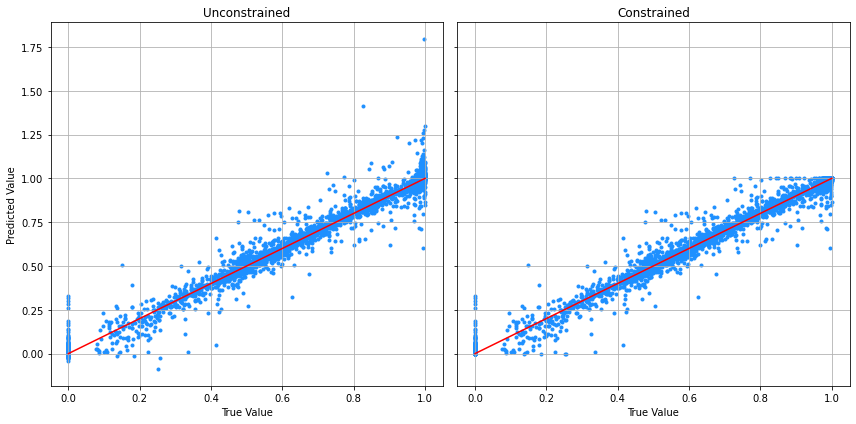

In [46]:
fig1, ax1 = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)


y_test_norm = []
y_pred_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, y_test, y_pred, y_pred_constrained):
    y_test_norm.append( y_t / m_tot )
    y_pred_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    

ax = ax1[0]

ax.set_title('Unconstrained')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

ax.grid(True)

ax.scatter(y_test_norm, y_pred_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = ax1[1]

ax.set_title('Constrained')
ax.set_xlabel('True Value')

ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')

plt.tight_layout()